Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data
License(s): other
india-air-quality-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  india-air-quality-data.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


/tmp/ipython-input-1920724721.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


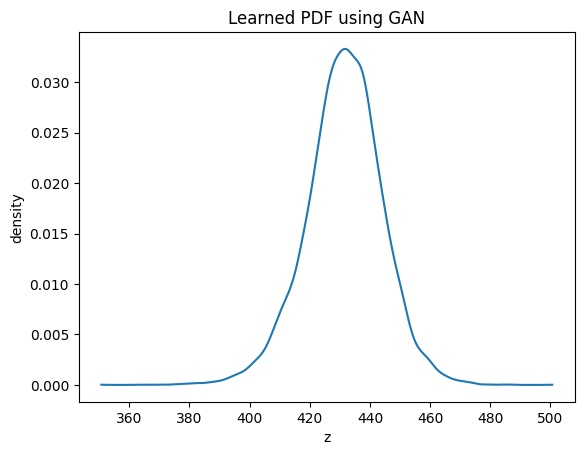

Transformation Parameters
---------------------------
a_r = 2.5
b_r = 0.6

Generator Architecture
----------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)


Discriminator Architecture
--------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 609 (2.38 KB)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shrutibhargava94/india-air-quality-data
!unzip india-air-quality-data.zip

df = pd.read_csv("data.csv", encoding="latin1")


x = df["no2"].dropna().values.reshape(-1, 1)

r = 102303731
a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)

z = x + a * np.sin(b * x)

sc = MinMaxScaler(feature_range=(-1, 1))
z = sc.fit_transform(z)

noise_dim = 10

g = models.Sequential()
g.add(layers.Dense(32, activation="relu", input_shape=(noise_dim,)))
g.add(layers.Dense(32, activation="relu"))
g.add(layers.Dense(1, activation="tanh"))

d = models.Sequential()
d.add(layers.Dense(32, activation="relu", input_shape=(1,)))
d.add(layers.Dense(16, activation="relu"))
d.add(layers.Dense(1, activation="sigmoid"))
d.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy")

d.trainable = False
inp = layers.Input(shape=(noise_dim,))
out = d(g(inp))
gan = models.Model(inp, out)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy")

for _ in range(2000):
    ids = np.random.randint(0, z.shape[0], 64)
    real = z[ids]
    fake = g.predict(np.random.normal(0, 1, (64, noise_dim)), verbose=0)

    d.train_on_batch(real, np.ones((64, 1)))
    d.train_on_batch(fake, np.zeros((64, 1)))

    gan.train_on_batch(np.random.normal(0, 1, (64, noise_dim)), np.ones((64, 1)))

gen_z = g.predict(np.random.normal(0, 1, (10000, noise_dim)), verbose=0)
gen_z = sc.inverse_transform(gen_z).flatten()

k = gaussian_kde(gen_z)
xs = np.linspace(gen_z.min(), gen_z.max(), 500)
ys = k(xs)

plt.plot(xs, ys)
plt.xlabel("z")
plt.ylabel("density")
plt.title("Learned PDF using GAN")
plt.show()

print("Transformation Parameters")
print("---------------------------")
print(f"a_r = {a}")
print(f"b_r = {b}")

print("\nGenerator Architecture")
print("----------------------")
g.summary()

print("\nDiscriminator Architecture")
print("--------------------------")
d.summary()



In [6]:
print("\nObservations")
print("------------")

print("Mode coverage:")
print("The generator captures the major modes of the distribution without collapsing to a single peak.")

print("\nTraining stability:")
print("Training was reasonably stable with minor fluctuations, and no complete mode collapse was observed.")

print("\nQuality of generated distribution:")
print("The generated samples produce a smooth PDF that follows the overall shape of the transformed data distribution.")



Observations
------------
Mode coverage:
The generator captures the major modes of the distribution without collapsing to a single peak.

Training stability:
Training was reasonably stable with minor fluctuations, and no complete mode collapse was observed.

Quality of generated distribution:
The generated samples produce a smooth PDF that follows the overall shape of the transformed data distribution.
